# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 8: mass ratio and secondary BH mass
### (As seen by a 'perfect detector')



## Imports and definitions:

In [3]:
######################################
## Imports
import numpy as np
import h5py as h5

from astropy.table import Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm

from scipy import stats

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# Extra python functions
import HelperFunctions as func
import importlib
importlib.reload(func)

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 


In [4]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
DCO.info()
'''

################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])
DCO['M_lessMassive']         = np.minimum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])
DCO['q_final']              = DCO['M_lessMassive']/DCO['M_moreMassive']

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
intrinsic_rate_density       = File[rate_key]['merger_rate'][()]
redshifts                    = File[rate_key]['redshifts'][()]

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16

# Filter both the BBH table and the intrinsic rate data
merging_BBH         = DCO[DCO_mask * nonCHE_bool]
Red_intr_rate_dens  = intrinsic_rate_density[rate_nonCHE_bool, :]


../output/COMPAS_Output_wWeights.h5



# Other observables (Mchirp, Mtot, M2)

In [11]:

def plot_dist(table, x_key, WEIGHTS, xlabel,
              bins = np.arange(0,50,2), kde_width = 0.1, 
              redshift_list = redshifts, 
              x_KDE = np.arange(0.,50.,2), 
              bootstrap  = False, bootstraps = 100, FIGSIZE=(11, 8),
              logx = False, show_x_on_log = True, logy=False, x_lim=(0,50), y_lim=None, save_plot=False,
              fill = True, All = True, show_hist = True, show_KDE = True, savestr='',
              ylabel=r'$R_{\mathrm{BBH} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$',
              colors = ['grey' ,'#73bdb3',  '#e388b0']):
    """
    Function to plot the weighted disrtibution for the stable RLOF and the CE channel seperately
    
    table         -------> [astropy table] the table that you would like to plot
    x_key         -------> [str] what key in table to plot the distribution of
    WEIGHTS       -------> [array] list of weights (usually the rate) to weigh dist. (same len as table)
    
    SW            -------> [bool] if true, use 'mixture_weight' = stroopwafel as weight
    redshift_list -------> [array] if WEIGHTS represent Rates you need redshift to convert too detector frame
    fill          -------> [bool] fill the plt.plot with a light shade
    All           -------> [bool] Add a line for the total dist
    bins          -------> [array] how to bin your x_key
    kde_width     -------> [float] bw metthod of KDE
    logy          -------> [bool] if you want the y-scale in log
    logx           -------> [bool] if you want log10(x), make sure to adjust bins!
    x_lim         -------> [min,max] x lim of plot
    xlabel        -------> [str] x axis label
    colors        -------> [array] 2 colours representing [CE, stable RLOF]
    save_plot     -------> [bool] save plot or not
    """
    #########################################
    # centers of redshif bins
    center_z = (redshift_list[:-1] + redshift_list[1:])/2.
    # Calculate the volume of the fine redshift bins
    fine_volumes       = cosmo.comoving_volume(redshift_list).to(u.Gpc**3).value
    fine_shell_volumes = np.diff(redshift_list) #same len in z dimension as weight

    # Multiply intrinsic rate density by volume of the redshift shells in detector frame, to get the rate as seen by "perfect" detector
    R_perfect_det      = np.sum(WEIGHTS[:,:] * fine_shell_volumes[:] * 1./(1+center_z), axis = 1)
    
    print(np.shape(R_perfect_det), np.shape(table))
    
    #########################################
    # Bools and labels to split by stable RLOF vs CE channel
    Bool_list = [np.full(len(table), True), table['CE_Event_Count'] > 0, table['CE_Event_Count'] == 0 ]
    labels     = ['$\mathrm{All \ BBHs}$', '$\mathrm{CE \ channels}$', '$\mathrm{Stable \ RLOF \ channel}$']

    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = FIGSIZE)

    hatches = ['', '/', 'x', 'o' ]

    for i, Bool in enumerate(Bool_list):
        if i == 0:
            if not All:
                continue
            Fill, Show_hist = False, False
        else:
            Fill, Show_hist = fill, show_hist
        ########################
        # X and weight values
        m_Weight = R_perfect_det[Bool]

        x_vals = table[x_key][Bool]        
        if logx: # Assuming you've provided bin in logx!
            # Change of variables
            x_vals = np.log10(x_vals)
            
            # Set the ticks in non log format for readibility
            x_pow = np.arange(x_lim[0], x_lim[-1], 1.)
            plt.xticks(x_pow, ['$%s$'%(x) for x in 10**x_pow])
        else:
            if show_x_on_log: 
                ax.set_xscale('log')
                
        ########################
        # Plot the Hist    
        hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
        center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
        binwidth = np.diff(bins)
        #print('center_bins',center_bins, 'binwidth', binwidth)
        if Show_hist:
            ax.bar(center_bins, hist/binwidth, width= binwidth, #
                   alpha=1.,  color='white', fill=True, edgecolor=colors[i],
                   lw = 1., zorder = i, hatch = hatches[i]) 
        
        ########################
        # Add the KDE
        if show_KDE:
            kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=m_Weight)
            #center_bins#
            center_KDEbins = (x_KDE[:-1] + x_KDE[1:])/2.
            y_vals = kernel(center_KDEbins)*sum(hist)#/binwidth) * (np.diff(x_KDE))#re-normalize the KDE
            ax.plot(center_KDEbins, y_vals, lw=5, color=colors[i], zorder = i+1,label = labels[i])
            if Fill:
                ax.fill_between(center_KDEbins,y1=0, y2=y_vals, color=colors[i], zorder = i+2, alpha = 0.1)
                ax.fill_between(center_KDEbins,y1=0, y2=y_vals, facecolor="none", edgecolor=colors[i],zorder = i+3, hatch = hatches[i])

                
        ########################
        # Bootstrap        
        if bootstrap:
            indices = np.arange(len(x_vals))
            hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
            for b in func.progressbar( range(len(hist_vals)), "Bootstrapping "+ labels[i] + ":"):
                boot_index = np.random.choice(indices, size=len(indices), replace=True)

                kernel       = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights=m_Weight[boot_index])
                Hist, _      = np.histogram(x_vals[boot_index], bins=bins,weights=m_Weight[boot_index],density=False)

                hist_vals[b] = kernel(x_KDE)*sum(Hist)

            # calculate 1- and 2- sigma percentiles
            percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
            median = np.percentile(hist_vals, [50], axis=0)
            
            ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors[i], zorder = 11) # 1-sigma
            ax.fill_between(x_KDE, percentiles[2], percentiles[3],alpha=0.2, color=colors[i], zorder = 10) # 2-sgima    
    


        
    #########################################
    # plot values
    if x_lim != None:
        ax.set_xlim(x_lim)
    if y_lim != None:
        ax.set_ylim(y_lim)
    leg = ax.legend(fontsize = 20, loc = 'upper right')

    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    
    if logy:
        ax.set_yscale('log')

    if save_plot:
        print('saving', save_loc+'/png_versions/'+savestr+x_key+'_formdist.png')
        plt.savefig(save_loc+'/'+savestr+x_key+'_formdist.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/'+savestr+x_key+'_formdist.png', bbox_inches='tight')

    plt.show()

    
    




    

(2252487, 200) (2252487,)
(2252487,) (2252487,)


KeyboardInterrupt: 

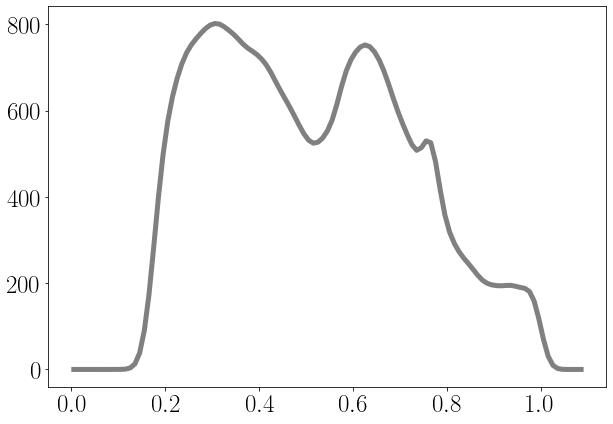

In [12]:
print(np.shape(Red_intr_rate_dens), np.shape(merging_BBH))

plot_dist(merging_BBH, 'q_final', Red_intr_rate_dens, 
          bootstrap  = True, bootstraps = 50, show_hist=False, fill = True, FIGSIZE=(10, 7),
          xlabel = '$q_{\mathrm{final}} \equiv M_{\mathrm{BH,2}}/M_{\mathrm{BH,1}} $', 
          ylabel='$\mathcal{R}^{\mathrm{det}}_{\mathrm{Univ}}/dq \ \mathrm{[yr^{-1}]}$',
          x_lim = (0,1), y_lim=(0,1200), show_x_on_log =False, show_KDE = True, 
          bins = np.arange(0,1.1,0.02),  kde_width = 0.075, x_KDE = np.arange(0,1.1,0.01),
          save_plot = False, savestr = sim_save_str)




(2252487,) (2252487,)
Bootstrapping: [############################################################] 50/50
Bootstrapping: [############################################################] 50/50
Bootstrapping: [############################################################] 50/50


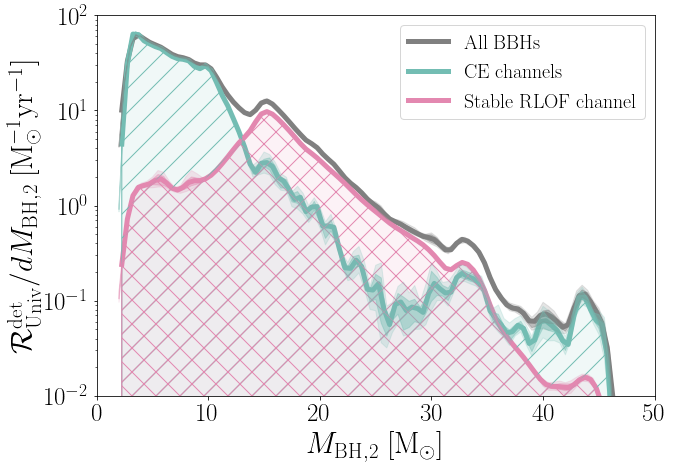

In [7]:

plot_dist(merging_BBH, 'M_lessMassive', Red_intr_rate_dens, 
          FIGSIZE=(10, 7), bootstrap  = True, bootstraps = 50, 
          fill = True, show_hist=False, 
          xlabel = '$M_{\mathrm{BH,2} \ } [\mathrm{M_{\odot}} ]$',
          ylabel='$\mathcal{R}^{\mathrm{det}}_{\mathrm{Univ}}/dM_{\mathrm{BH,2}} \ \mathrm{[M_{\odot}^{-1} yr^{-1}]}$',
          y_lim=(1e-2, 1e2), x_lim=(0,50),logy=True, logx = False, show_x_on_log = False,
          bins = np.arange(2,50,1), kde_width = 0.1, x_KDE = np.arange(2,50.,0.5),
          save_plot=True, savestr = sim_save_str)
